In [1]:
%reset -f
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
mpl.rc('axes', labelsize=20)
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)
dpi=320
# mpl.rc('title', fontsize=30)
from joblib import load
import numpy as np
import tensorflow as tf
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    print("failed to disable gpu")
    # Invalid device or cannot modify virtual devices once initialized.
    pass
print(tf.config.get_visible_devices())
tf.random.set_seed(42)

from modules.param_wgan_gp import WGAN, build_param_dict
from json import load as jload
from modules.KinTool import KinTool
# from data.custom_scaler import custom_scaler
from data.custom_scalerTF import custom_scalerTF

mname, epoch = "CM_small_dLNdKR", 3
print(mname, epoch)
with open(f"models/{mname}/model_params.json") as ff:
# with open(f"model_params_{mname}.json") as ff:
    param_dict = build_param_dict(jload(ff))
wgan = WGAN(**param_dict)
wgan.gen.load_weights(f"models/{mname}/epoch{epoch}/generator_weights.h5")
wgan.dis.load_weights(f"models/{mname}/epoch{epoch}/discriminator_weights.h5")
# wgan.gen.load_weights(f"generator_weights_{mname}.h5")
# wgan.dis.load_weights(f"discriminator_weights_{mname}.h5")

# param_dict["CM"] = False

# print(param_dict)
train = np.load("data/raw/X.npy")#[:10000000]#np.load(param_dict["train_set"])#
if 'cs_sclr' in param_dict['scaler']:
    sclr = custom_scalerTF()
else:
    sclr = load(param_dict['scaler'])



# feature_names = ["Q2", "W", "Gamnu", "Xbj", "y", "t", "phih", #MCEG feature names
#                             *[p+v for v in ["px", "py", "pz", "E"] for p in ["electron ", "photon ", "proton "]]]#param_dict['feat_names']
feature_names = param_dict['feat_names']
print(train.shape)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
CM_small_dLNdKR 3
(52871808, 6)


In [2]:
n_samples, batch_size = train.shape[0], 250000
print(f"Nb samples: {n_samples}\nbatch size: {batch_size}")
pred = np.zeros((n_samples,param_dict["MCEG_feats"]))

for i, ss in enumerate(np.arange(batch_size, n_samples+batch_size, batch_size)):
    if ss > n_samples:# not the most elegant but works
        ss = n_samples
    pred[i*batch_size:ss,:] = sclr.inverse_transform(wgan.gen(tf.random.normal(shape=(ss - i*batch_size, param_dict['latent_dim'])), training=False))
    # pred[i*batch_size:ss,:] = sclr.inverse_transform(wgan.gen.predict_on_batch(tf.random.normal(shape=(ns, param_dict['latent_dim']))))
    # pred[i*batch_size:ss,:] = sclr.inverse_transform(wgan.gen.predict(tf.random.normal(shape=(ns, param_dict['latent_dim']))))

if param_dict['CM']:
    # train = train[:,:pred.shape[1]]
    # train = sclr.inverse_transform(train)
    train[:,-1] = train[:,-1] - 360 * (train[:,-1]>180)
    feature_names = [r"$Q^2$ [GeV$^2$]", r"$W$", r"$x_{Bj}$", r"$y$", r"$-t$ [GeV$^2$]", r"$\phi_{HADRON}$"]
    # feature_names = [r"$Q^2$ [GeV$^2$]", r"$W$", r"$\nu$", r"$x_{Bj}$", r"$y$", r"$-t$ [GeV$^2$]", r"$\phi_{HADRON}$"]

Nb samples: 52871808
batch size: 250000


In [3]:
# TOPEG interactive: real 362m6.368s, user 361m51.997s, sys 0m3.475s
# TOPEG batch nodes: 36080.01user 74.13system 10:02:37elapsed 99%CPU (0avgtext+0avgdata 398000maxresident)k 3120inputs+15528outputs (3major+567529minor)pagefaults 0swaps

# CM_small_dLNdKR CPU: 278 ms ± 3.61 ms
%timeit sclr.inverse_transform(wgan.gen(tf.random.normal(shape=(100000, param_dict['latent_dim'])), training=False))

278 ms ± 3.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
[ i/(25000*1000)*100 for i in [24500100, 24430100, 24430100, 24470100] ]

[98.0004, 97.7204, 97.7204, 97.8804]

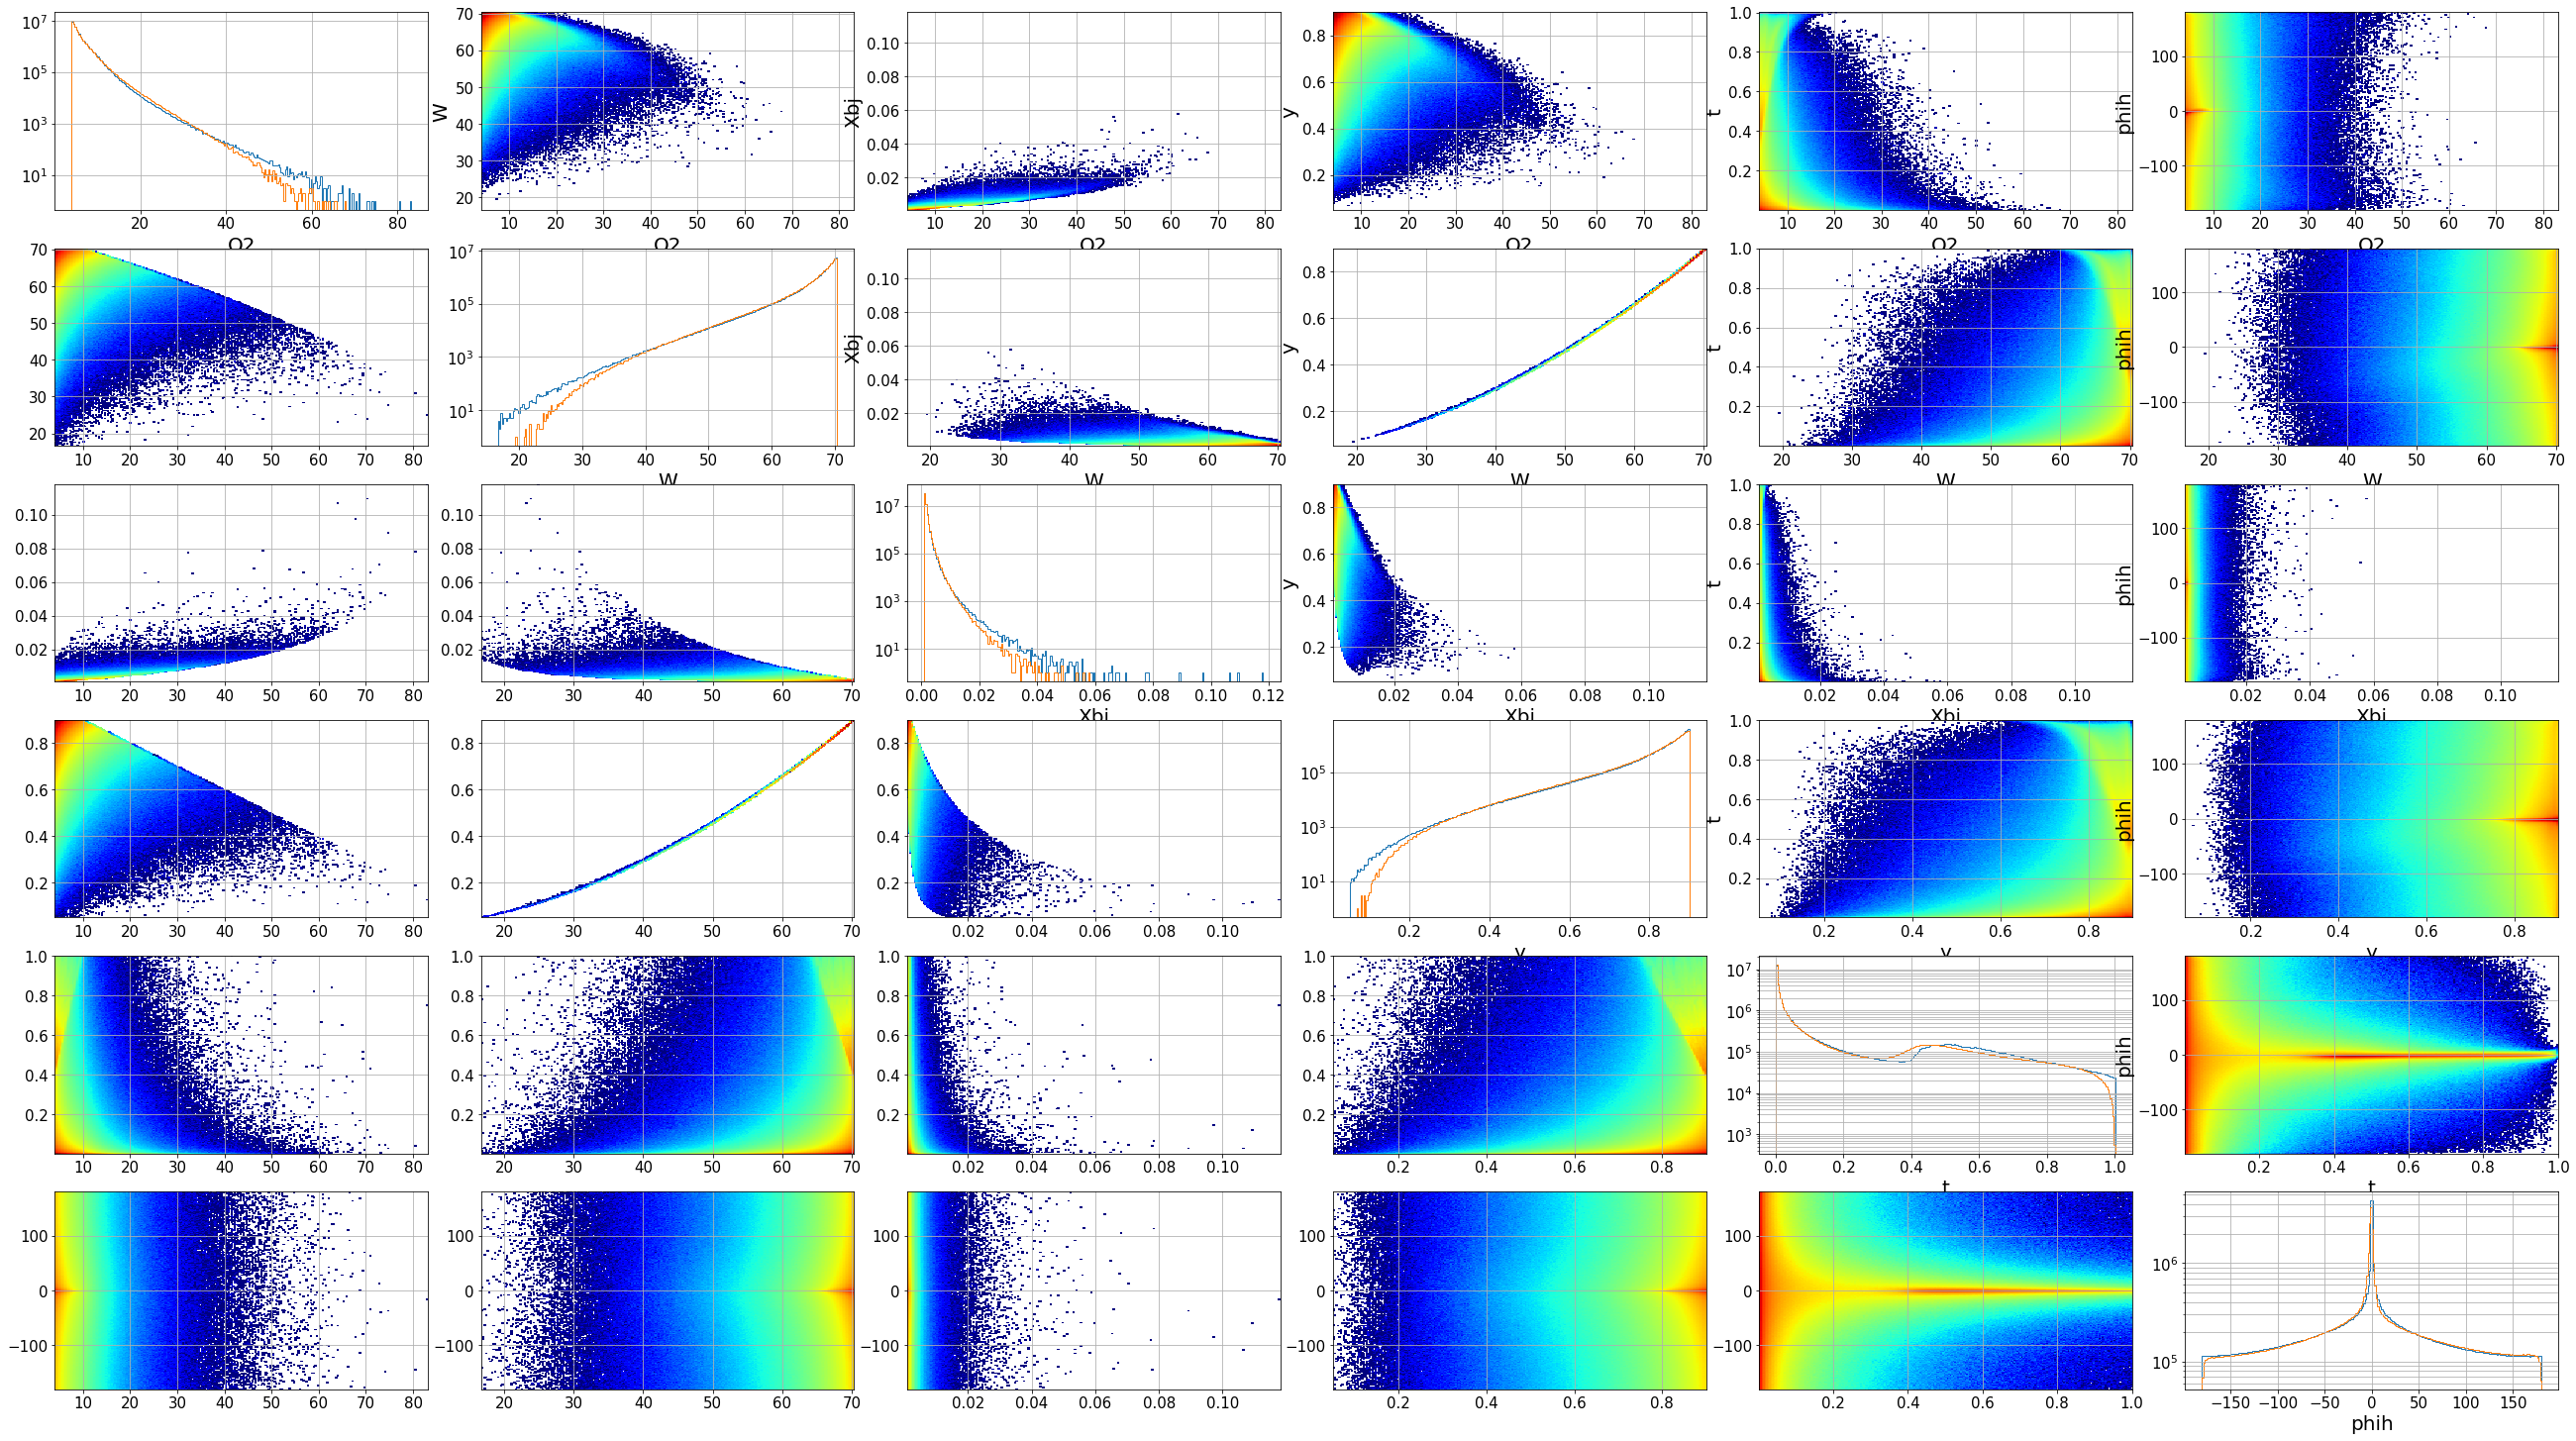

In [5]:
f, axs = plt.subplots(6,6, figsize=(36,20)); f.tight_layout()
# nns = ["Q2", "W", "Gamnu", "Xbj", "y", "t", "phih"]
nns = ["Q2", "W", "Xbj", "y", "t", "phih"]
for i, ni in enumerate(nns):
    for j, nj in enumerate(nns):
        if i == j:
            bins = np.linspace(np.min(np.r_[train[:,i], pred[:,i]]), np.max(np.r_[train[:,i],pred[:,i]]), 250+1)
            axs[i,j].hist(train[:,i], histtype='step', bins=bins)
            axs[i,j].hist(pred[:,i], histtype='step', bins=bins)
            axs[i,j].set_xlabel(ni)
            axs[i,j].set_yscale('log')
            axs[i,j].grid(which='both')
        elif j > i:
            binsx = np.linspace(np.min(np.r_[train[:,i], pred[:,i]]), np.max(np.r_[train[:,i],pred[:,i]]), 250+1)
            binsy = np.linspace(np.min(np.r_[train[:,j], pred[:,j]]), np.max(np.r_[train[:,j],pred[:,j]]), 250+1)
            axs[i,j].hist2d(pred[:,i],pred[:,j], bins=[binsx,binsy], cmap="jet", norm=mpl.colors.LogNorm())
            axs[j,i].hist2d(train[:,i],train[:,j], bins=[binsx,binsy], cmap="jet", norm=mpl.colors.LogNorm())
            axs[i,j].set_xlabel(ni)
            axs[i,j].set_ylabel(nj)
            axs[i,j].grid(which='both')
            axs[j,i].grid(which='both')


chi2 =  11677989.899303745


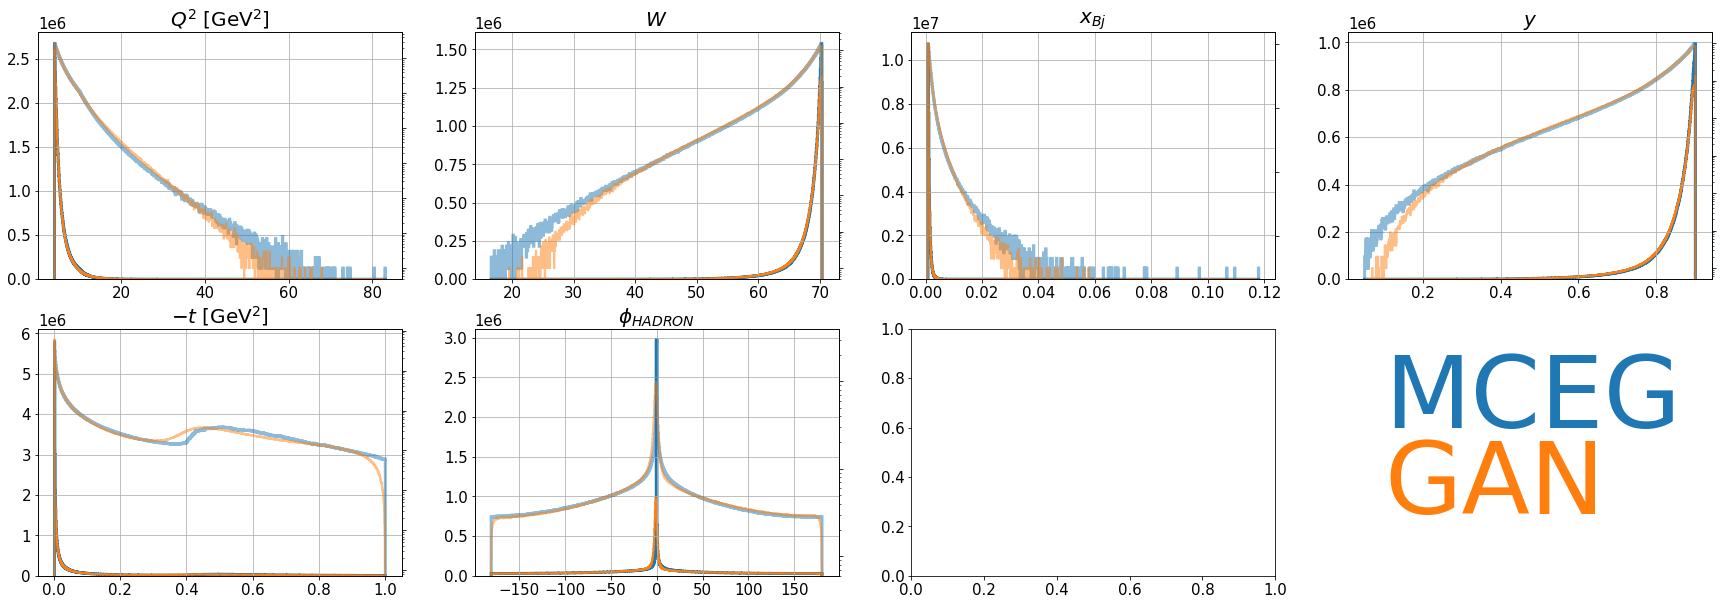

In [6]:
# f, axs = plt.subplots(4,5, figsize=(36,20)); f.tight_layout()
# axs = axs.flatten()
# chi2=0
# for i in range(pred.shape[1]):
#     ax = axs[i]
#     alpha = 1
#     ax.grid(which='both')
#     ax.set_title(feature_names[i], fontsize=20)
#     ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#     for k in range(2):
#         if k == 1:
#             ax = ax.twinx()
#             ax.set_yscale('log')
#             alpha = 0.5
#             ax.set_yticklabels([])
#         bins = np.linspace(np.min(np.r_[train[:,i], pred[:,i]]), np.max(np.r_[train[:,i],pred[:,i]]), 1000+1)
#         vr, _, _ = ax.hist(train[:,i],histtype='step',bins=bins, label="MCEG", linewidth=3, alpha=alpha)#, weights=np.ones_like(train[:,i])/len(train))#, density=train)
#         vf, _, _ = ax.hist(pred[:,i],histtype='step',bins=bins, label="WGAN", linewidth=2, alpha=alpha)#, weights=np.ones_like(pred[:,i])/len(pred))#, density=train)
#     chi2 += np.sum(((vr-vf)/(np.max([np.ones_like(vr),np.sqrt(vr)], axis=0)))**2)#np.sqrt(vr)
#         # ax.set_xlim([-1.1,1.1])
#     # ax.legend()
# axs[-1].set_axis_off()
# axs[-1].text(0.1, 0.6, "MCEG", fontsize=100, color='C0')
# axs[-1].text(0.1, 0.3, "WGAN", fontsize=100, color='C1')
# # axs[-1].text(0.1, 0.1, "Epoch", fontsize=100, color='C1')

# print("chi2 = ",chi2)
# f.savefig(f"imgs/train_train_all_features.png", bbox_inches='tight')#, dpi=dpi)

f, axs = plt.subplots(2,4, figsize=(30,10)); #f.tight_layout()
axs = axs.flatten()
chi2=0
for i in range(pred.shape[1]):
    ax = axs[i]
    alpha = 1
    ax.grid(which='both')
    ax.set_title(feature_names[i], fontsize=20)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    for k in range(2):
        if k == 1:
            ax = ax.twinx()
            ax.set_yscale('log')
            alpha = 0.5
            ax.set_yticklabels([])
        bins = np.linspace(np.min(np.r_[train[:,i], pred[:,i]]), np.max(np.r_[train[:,i],pred[:,i]]), 1000+1)
        vr, _, _ = ax.hist(train[:,i],histtype='step',bins=bins, label="MCEG", linewidth=3, alpha=alpha)#, weights=np.ones_like(train[:,i])/len(train))#, density=train)
        vf, _, _ = ax.hist(pred[:,i],histtype='step',bins=bins, label="GAN", linewidth=2, alpha=alpha)#, weights=np.ones_like(pred[:,i])/len(pred))#, density=train)
    chi2 += np.sum(((vr-vf)/(np.max([np.ones_like(vr),np.sqrt(vr)], axis=0)))**2)#np.sqrt(vr)
        # ax.set_xlim([-1.1,1.1])
    # ax.legend()
axs[-1].set_axis_off()
axs[-1].text(0.1, 0.6, "MCEG", fontsize=100, color='C0')
axs[-1].text(0.1, 0.25, "GAN", fontsize=100, color='C1')
# axs[-1].text(0.1, 0.1, "Epoch", fontsize=100, color='C1')

print("chi2 = ",chi2)
f.savefig(f"imgs/train_train_all_features.png", bbox_inches='tight')#, dpi=dpi)

# f, axs = plt.subplots(4,2, figsize=(10,20)); #f.tight_layout()
# axs = axs.flatten()
# chi2=0
# for i in range(pred.shape[1]):
#     ax = axs[i]
#     alpha = 1
#     ax.grid(which='both')
#     ax.set_title(feature_names[i], fontsize=20)
#     ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#     for k in range(2):
#         if k == 1:
#             ax = ax.twinx()
#             ax.set_yscale('log')
#             alpha = 0.5
#             ax.set_yticklabels([])
#         bins = np.linspace(np.min(np.r_[train[:,i], pred[:,i]]), np.max(np.r_[train[:,i],pred[:,i]]), 1000+1)
#         vr, _, _ = ax.hist(train[:,i],histtype='step',bins=bins, label="MCEG", linewidth=3, alpha=alpha)#, weights=np.ones_like(train[:,i])/len(train))#, density=train)
#         vf, _, _ = ax.hist(pred[:,i],histtype='step',bins=bins, label="WGAN", linewidth=2, alpha=alpha)#, weights=np.ones_like(pred[:,i])/len(pred))#, density=train)
#     chi2 += np.sum(((vr-vf)/(np.max([np.ones_like(vr),np.sqrt(vr)], axis=0)))**2)#np.sqrt(vr)
#         # ax.set_xlim([-1.1,1.1])
#     # ax.legend()
# axs[-1].set_axis_off()
# axs[-1].text(0.01, 0.6, "MCEG", fontsize=75, color='C0')
# axs[-1].text(0.01, 0.25, "WGAN", fontsize=75, color='C1')
# # axs[-1].text(0.1, 0.1, "Epoch", fontsize=100, color='C1')

# print("chi2 = ",chi2)
# f.savefig(f"imgs/train_train_all_features_vertical.png", bbox_inches='tight')#, dpi=dpi)

In [7]:
def mpl_labels(ax, x, y, lab, title, fontsize=20):
    ax.set_xlabel(x, fontsize=fontsize)
    if lab == "MCEG": ax.set_ylabel(y, fontsize=fontsize)
    ax.set_title(lab+" "+title, fontsize=fontsize)
    ax.grid()

In [8]:
# f, axs = plt.subplots(3,4, figsize=(30,15));# f.tight_layout()
# axs, bc = axs.flatten(), 500
# a = 0
# for i, n in zip([7, 8, 9], ["Electron", "Photon", "Proton"]):
#     for j, p in zip(range(4), [r"$p_x$", r"$p_y$", r"$p_z$", r"Energy"]):
#         axs[a].set_title(n+" "+p, fontsize=20)
#         # axs[a].set_xlabel(p, fontsize=16)
#         # axs[a].xaxis.set_label_coords(1.05, -0.025)
#         axs[a].grid(which='both')
#         bins = np.linspace(np.min(np.r_[train[:,i+j*3], pred[:,i+j*3]]), np.max(np.r_[train[:,i+j*3],pred[:,i+j*3]]), bc+1)
#         axs[a].hist(train[:,i+j*3], bins=bins, histtype="step", linewidth=3, label="MCEG")
#         axs[a].hist(pred[:,i+j*3], bins=bins, histtype="step", linewidth=2, label="GAN")
#         a+=1

# axs[3].text(.5, .75, "MCEG", transform=axs[3].transAxes, fontsize=60, color='C0')
# axs[3].text(.5, .5, "GAN", transform=axs[3].transAxes, fontsize=60, color='C1')

# f.savefig(f"imgs/mom_dists_linear.png", facecolor="white", bbox_inches='tight', dpi=dpi)


In [9]:
# f, axs = plt.subplots(3,4, figsize=(30,15));# f.tight_layout()
# axs, bc = axs.flatten(), 500
# a = 0
# for i, n in zip([7, 8, 9], ["Electron", "Photon", "Proton"]):
#     for j, p in zip(range(4), [r"$p_x$", r"$p_y$", r"$p_z$", r"Energy"]):
#         axs[a].set_yscale('log')
#         axs[a].set_title(n+" "+p, fontsize=20)
#         # axs[a].set_xlabel(p, fontsize=16)
#         # axs[a].xaxis.set_label_coords(1.05, -0.025)
#         axs[a].grid(which='both')
#         bins = np.linspace(np.min(np.r_[train[:,i+j*3], pred[:,i+j*3]]), np.max(np.r_[train[:,i+j*3],pred[:,i+j*3]]), bc+1)
#         axs[a].hist(train[:,i+j*3], bins=bins, histtype="step", linewidth=3, label="MCEG")
#         axs[a].hist(pred[:,i+j*3], bins=bins, histtype="step", linewidth=2, label="GAN")
#         a+=1

# axs[3].text(.5, .75, "MCEG", transform=axs[3].transAxes, fontsize=60, color='C0')
# axs[3].text(.5, .5, "GAN", transform=axs[3].transAxes, fontsize=60, color='C1')

# f.savefig(f"imgs/mom_dists_log.png", facecolor="white", bbox_inches='tight', dpi=dpi)


In [10]:
# f, axs = plt.subplots(2,1, figsize=(10,10));# f.tight_layout()
# axs, bc = axs.flatten(), 500
# a = 0

# for i, n in zip([6, 12], [r"$\phi$ Proton", r"Proton $p_y$"]):
#     # axs[a].set_yscale('log')
#     axs[a].set_title(n, fontsize=20)
#     axs[a].grid()
#     bins = np.linspace(np.min(np.r_[train[:,i], pred[:,i]]), np.max(np.r_[train[:,i],pred[:,i]]), bc+1)
#     axs[a].hist(train[:,i], bins=bins, histtype="step", linewidth=3, label="MCEG")
#     axs[a].hist(pred[:,i], bins=bins, histtype="step", linewidth=2, label="GAN")
#     a+=1

# axs[0].text(.82, .85, "MCEG", transform=axs[0].transAxes, fontsize=45, color='C0')
# axs[0].text(.82, .7, "GAN", transform=axs[0].transAxes, fontsize=45, color='C1')

# f.savefig(f"imgs/phih_propy.png", facecolor="white", bbox_inches='tight', dpi=dpi)


In [11]:
# train[:,6] = np.sign(train[:,6]) * np.log(1 + np.abs(train[:,6]))#/10**-3)# train[:,6] - 360 * (train[:,6]>180)
# pred[:,6] = np.sign(pred[:,6]) * np.log(1 + np.abs(pred[:,6]))#/1000**-3) #pred[:,6] - 360 * (pred[:,6]>180)

In [12]:
# # f, ax = plt.subplots(1, 1, figsize=(8,5));# f.tight_layout()
# # bc = 500

# # ax.set_yscale('log')
# # ax.set_title(r"Proton Energy", fontsize=20)
# # ax.grid()
# # bins = np.linspace(np.min(np.r_[train[:,-1], pred[:,-1]]), np.max(np.r_[train[:,-1],pred[:,-1]]), bc+1)
# # ax.hist(train[:,-1], bins=bins, histtype="step", linewidth=3, label="MCEG")
# # ax.hist(pred[:,-1], bins=bins, histtype="step", linewidth=2, label="GAN")

# # ax.text(.1, .85, "MCEG", transform=ax.transAxes, fontsize=45, color='C0')
# # ax.text(.1, .7, "GAN", transform=ax.transAxes, fontsize=45, color='C1')

# # f.savefig(f"imgs/proton_e.png", facecolor="white", bbox_inches='tight', dpi=dpi)

# f, axs = plt.subplots(2,1, figsize=(10,10));# f.tight_layout()
# axs, bc = axs.flatten(), 500
# a = 0

# for i, n in zip([6, -1], [r"$\phi_{trento}$", r"Proton Energy"]):
#     if a:
#         axs[a].set_yscale('log')
#         # axs[a].set_ylim([0, 100])
#     axs[a].set_title(n, fontsize=25)
#     axs[a].grid()
#     bins = np.linspace(np.min(np.r_[train[:,i], pred[:,i]]), np.max(np.r_[train[:,i],pred[:,i]]), bc+1)
#     axs[a].hist(train[:,i], bins=bins, histtype="step", linewidth=3, label="MCEG")
#     axs[a].hist(pred[:,i], bins=bins, histtype="step", linewidth=2, label="GAN")
#     a+=1

# axs[0].text(.82, .85, "MCEG", transform=axs[0].transAxes, fontsize=45, color='C0')
# axs[0].text(.82, .7, "GAN", transform=axs[0].transAxes, fontsize=45, color='C1')

# f.savefig(f"imgs/phih_proE.png", facecolor="white", bbox_inches='tight', dpi=dpi)



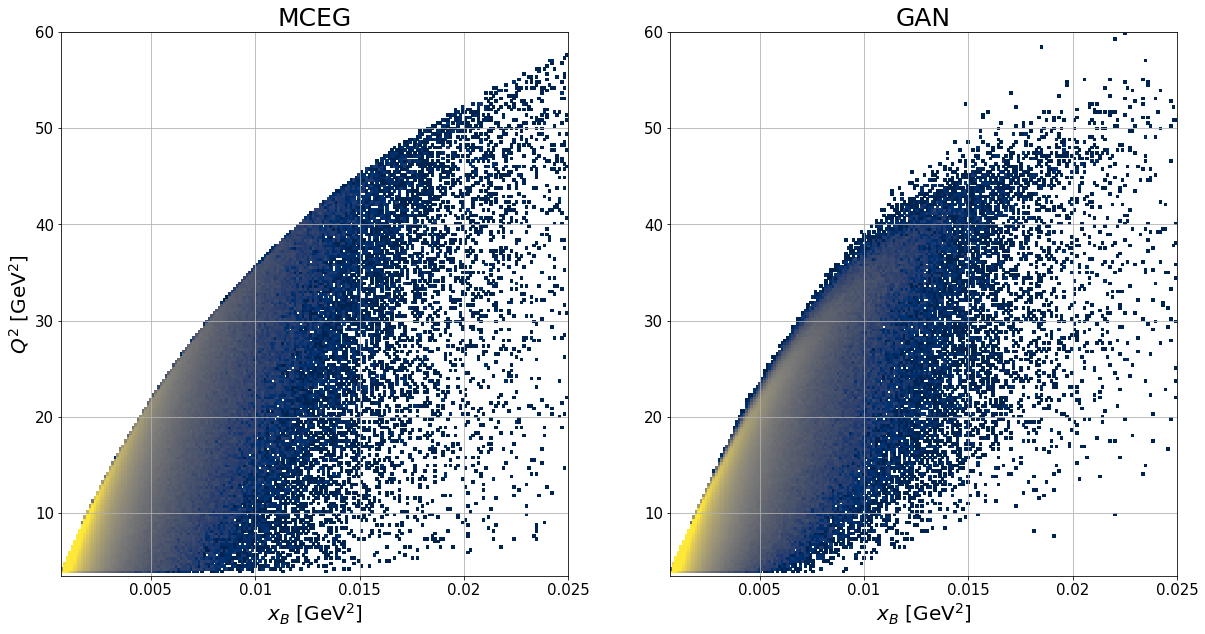

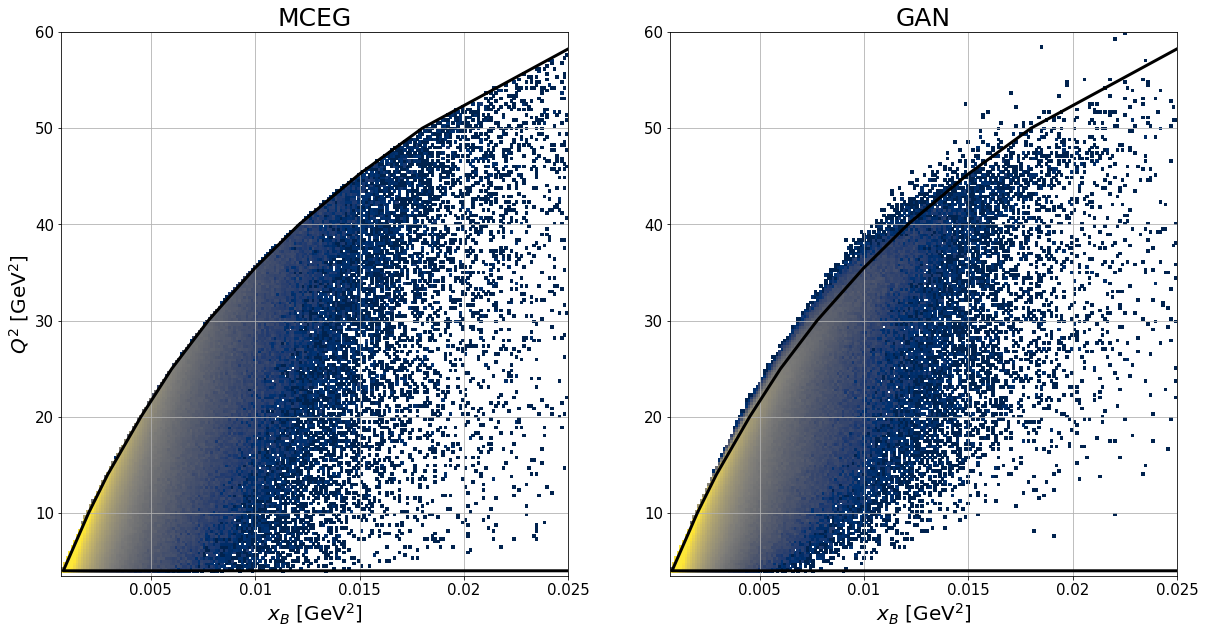

In [13]:
f, axs = plt.subplots(1,2, figsize=(20,10))#; f.tight_layout()
vmin, vmax = 1, 2500*50
xyrange, bins = [[0.0007, 0.025],[3.5, 60]], 200#(500,500)
for ax, hh, lab in zip(axs.flatten(), [train, pred], ["MCEG", "GAN"]):
    ax.hist2d(hh[:,3-1], hh[:,0], bins=bins, range=xyrange, cmap="cividis", norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
    ax.set_xlabel(r"$x_{B}$ [GeV$^2$]", fontsize=20)
    if lab == "MCEG": ax.set_ylabel(r"$Q^{2}$ [GeV$^2$]", fontsize=20)
    ax.set_title(lab, fontsize=25)
    ax.grid()
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    # ax.plot([0.005, 0.000805, 0.002015, 0.00293, 0.004522], [4, 4, 10, 14, 20], 'k', linewidth=2)
f.savefig(f"imgs/q2xb_vbig.png", bbox_inches='tight')#, dpi=500), facecolor="white"

f, axs = plt.subplots(1,2, figsize=(20,10))#; f.tight_layout()
for ax, hh, lab in zip(axs.flatten(), [train, pred], ["MCEG", "GAN"]):
    c, xb, yb, im = ax.hist2d(hh[:,3-1], hh[:,0], bins=bins, range=xyrange, cmap="cividis", norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
    # ax.contour(c.T,extent=[xb.min(),xb.max(),yb.min(),yb.max()],linewidths=3, cmap=plt.cm.Greys_r, levels=[10, 33, 100, 666, 5000, 25000])
    ax.set_xlabel(r"$x_{B}$ [GeV$^2$]", fontsize=20)
    if lab == "MCEG": ax.set_ylabel(r"$Q^{2}$ [GeV$^2$]", fontsize=20)
    ax.set_title(lab, fontsize=25)
    ax.grid()
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.plot([.1, 0.000805, 0.002015, 0.00293, 0.004522, 0.006, 0.00775, 0.01, 0.0121, 0.015, 0.018, 0.025], [4, 4, 10, 14, 20, 25, 30, 35.5, 40, 45.25, 50, 58.25], 'k', linewidth=3)

f.savefig(f"imgs/q2xb_vbig_lines.png", bbox_inches='tight')#, dpi=500), facecolor="white"

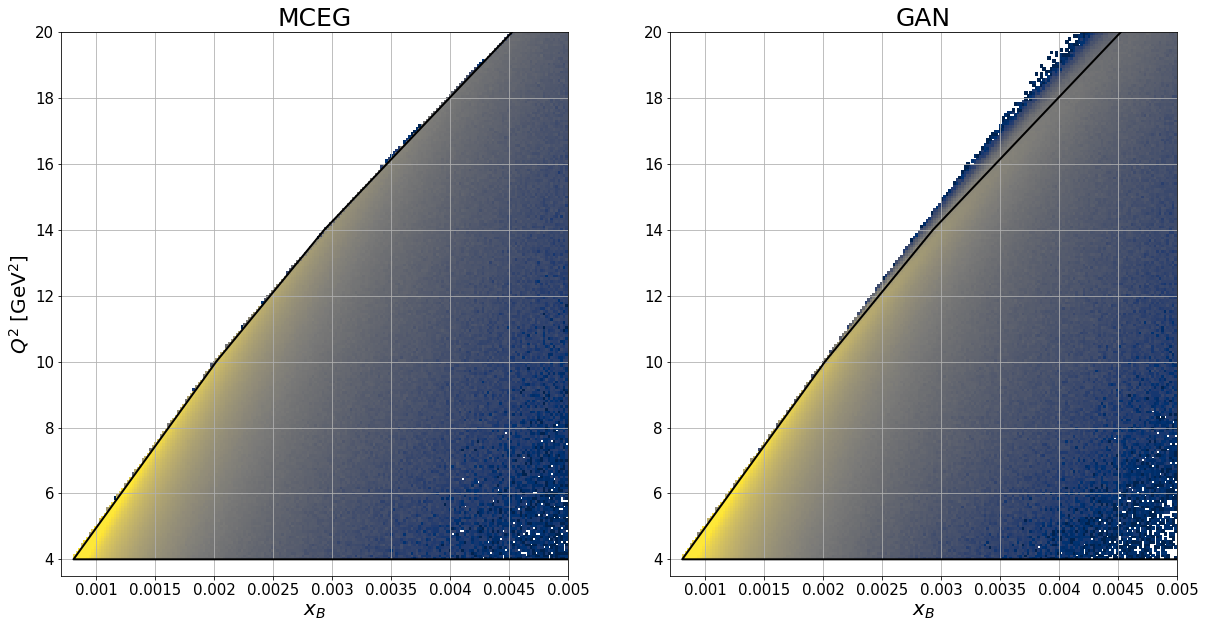

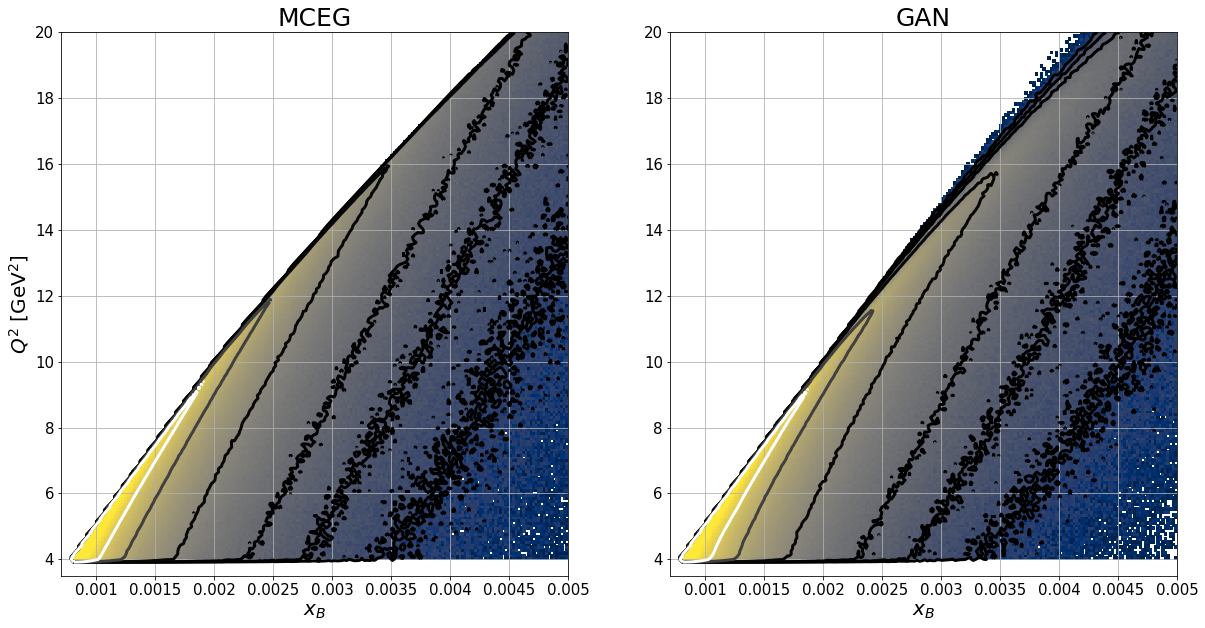

In [14]:
f, axs = plt.subplots(1,2, figsize=(20,10))#; f.tight_layout()
vmin, vmax = 1, 2500*50
xyrange, bins = [[0.0007, 0.005],[3.5, 20]], 200#(500,500)
for ax, hh, lab in zip(axs.flatten(), [train, pred], ["MCEG", "GAN"]):
    ax.hist2d(hh[:,3-1], hh[:,0], bins=bins, range=xyrange, cmap="cividis", norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
    ax.set_xlabel(r"$x_{B}$", fontsize=20)
    if lab == "MCEG": ax.set_ylabel(r"$Q^{2}$ [GeV$^2$]", fontsize=20)
    ax.set_title(lab, fontsize=25)
    ax.grid()
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.plot([0.005, 0.000805, 0.002015, 0.00293, 0.004522], [4, 4, 10, 14, 20], 'k', linewidth=2)
f.savefig(f"imgs/q2xb_big.png", bbox_inches='tight')#, dpi=500), facecolor="white"

f, axs = plt.subplots(1,2, figsize=(20,10))#; f.tight_layout()
for ax, hh, lab in zip(axs.flatten(), [train, pred], ["MCEG", "GAN"]):
    c, xb, yb, im = ax.hist2d(hh[:,3-1], hh[:,0], bins=bins, range=xyrange, cmap="cividis", norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
    ax.contour(c.T,extent=[xb.min(),xb.max(),yb.min(),yb.max()],linewidths=3, cmap=plt.cm.Greys_r, levels=[10, 33, 100, 666, 5000, 25000])
    ax.set_xlabel(r"$x_{B}$", fontsize=20)
    if lab == "MCEG": ax.set_ylabel(r"$Q^{2}$ [GeV$^2$]", fontsize=20)
    ax.set_title(lab, fontsize=25)
    ax.grid()
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    # ax.plot([0.005, 0.000805, 0.002015, 0.00293, 0.004522], [4, 4, 10, 14, 20], 'k', linewidth=3)

f.savefig(f"imgs/q2xb_big_lines.png", bbox_inches='tight')#, dpi=500), facecolor="white"

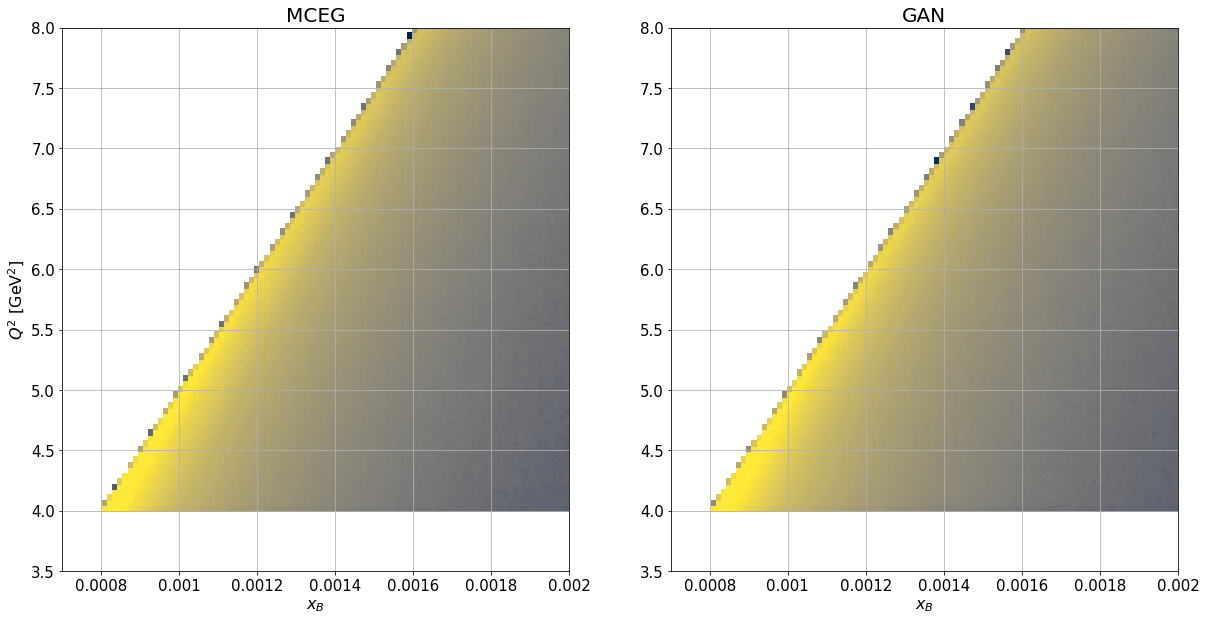

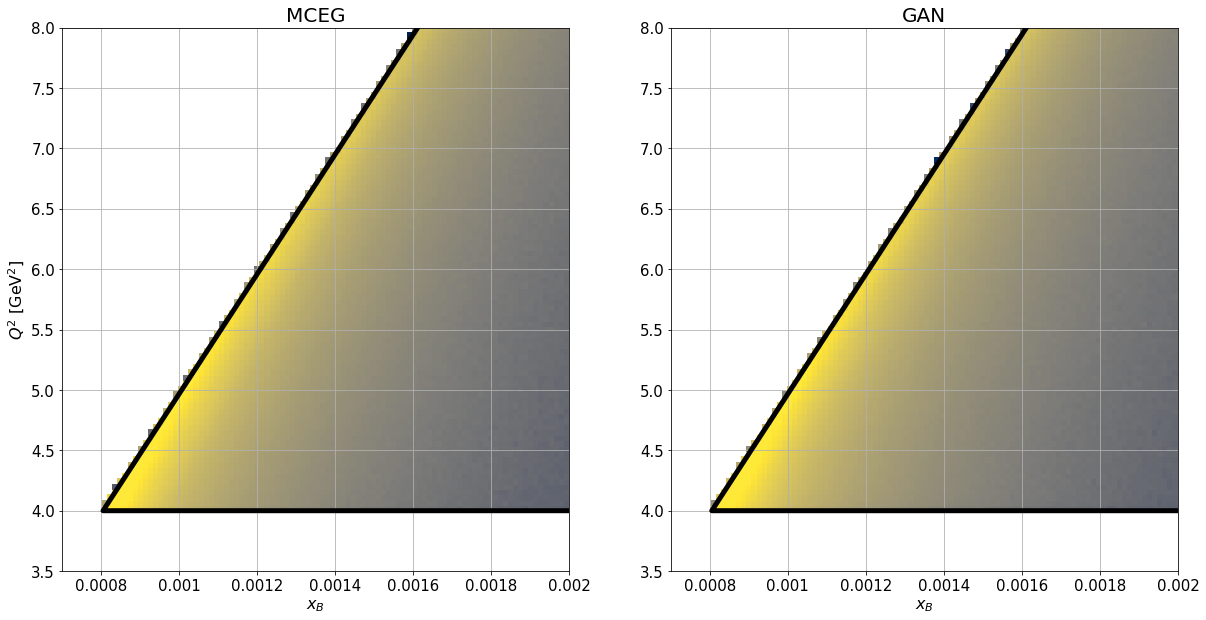

In [15]:
f, axs = plt.subplots(1,2, figsize=(20,10))#; f.tight_layout()
vmin, vmax = 1, 2500*50
xyrange, bins = [[0.0007, 0.002],[3.5, 8]], 100#(500,500)
for ax, hh, lab in zip(axs.flatten(), [train, pred], ["MCEG", "GAN"]):
    ax.hist2d(hh[:,3-1], hh[:,0], bins=bins, range=xyrange, cmap="cividis", norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
    ax.set_xlabel(r"$x_{B}$", fontsize=16)
    if lab == "MCEG": ax.set_ylabel(r"$Q^{2}$ [GeV$^2$]", fontsize=16)
    ax.set_title(lab, fontsize=20)
    ax.grid()
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
f.savefig(f"imgs/q2xb_zoom.png", bbox_inches='tight')#, dpi=500), facecolor="white"

f, axs = plt.subplots(1,2, figsize=(20,10))#; f.tight_layout()
for ax, hh, lab in zip(axs.flatten(), [train, pred], ["MCEG", "GAN"]):
    c, xb, yb, im = ax.hist2d(hh[:,3-1], hh[:,0], bins=bins, range=xyrange, cmap="cividis", norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
    # ax.contour(c.T,extent=[xb.min(),xb.max(),yb.min(),yb.max()],linewidths=3, cmap=plt.cm.Greys_r, levels=[10, 33, 100, 666, 5000, 25000])#[10, 33, 100, 1000, 10000])
    ax.set_xlabel(r"$x_{B}$", fontsize=16)
    if lab == "MCEG": ax.set_ylabel(r"$Q^{2}$ [GeV$^2$]", fontsize=16)
    ax.set_title(lab, fontsize=20)
    ax.grid()
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.plot([0.005, 0.000805, 0.002015, 0.00293, 0.004522], [4, 4, 10, 14, 20], 'k', linewidth=5)

f.savefig(f"imgs/q2xb_zoom_lines.png", bbox_inches='tight')#, dpi=500), facecolor="white"

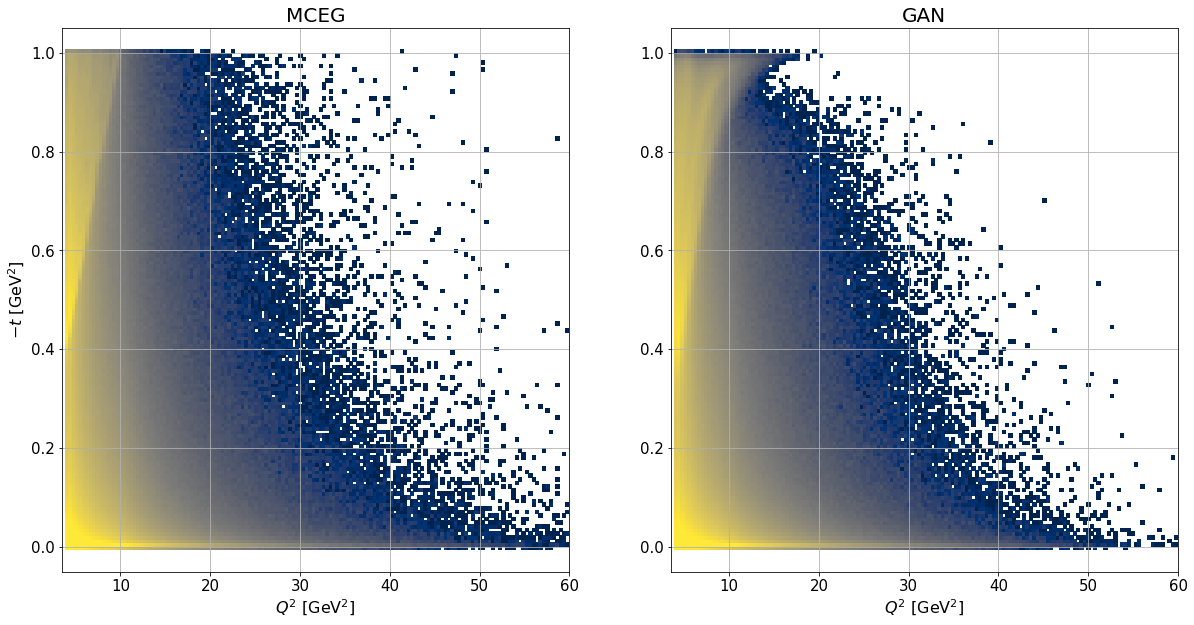

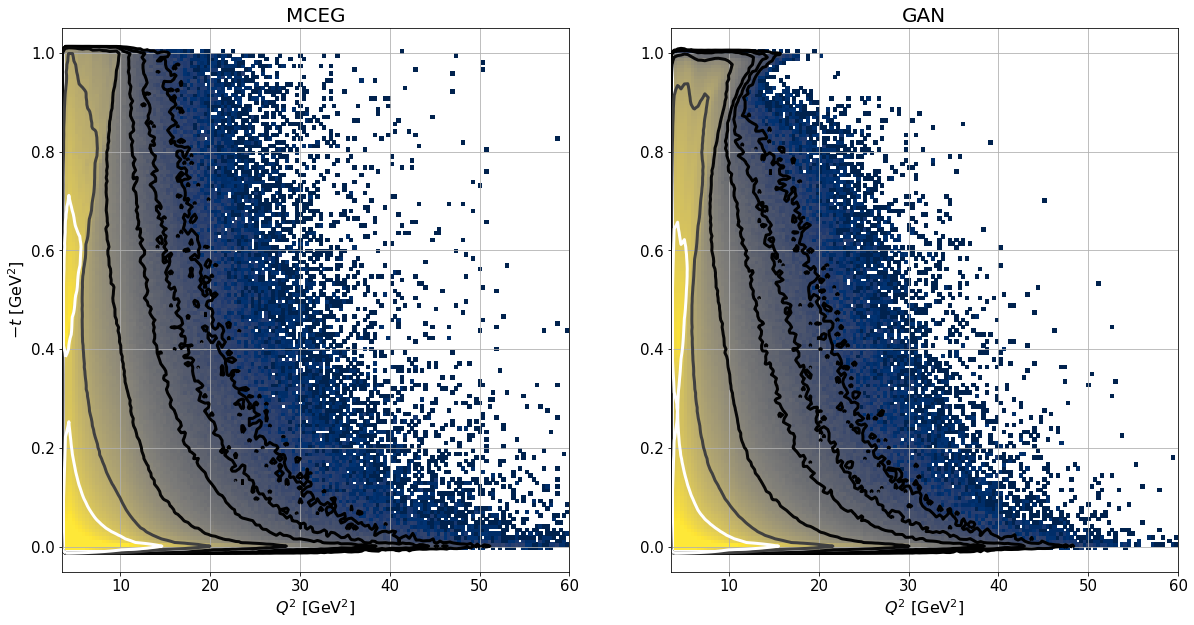

In [16]:
f, axs = plt.subplots(1,2, figsize=(20,10))#; f.tight_layout()
vmin, vmax = 1, 2500*50
xyrange, bins = [[3.5, 60],[-0.05, 1.05]], 150#(500,500)
for ax, hh, lab in zip(axs.flatten(), [train, pred], ["MCEG", "GAN"]):
    ax.hist2d(hh[:,0], hh[:,5-1], bins=bins, range=xyrange, cmap="cividis", norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
    ax.set_xlabel(r"$Q^{2}$ [GeV$^2$]", fontsize=16)
    if lab == "MCEG": ax.set_ylabel(r"$-t$ [GeV$^2$]", fontsize=16)
    ax.set_title(lab, fontsize=20)
    ax.grid()
# f.savefig(f"imgs/q2t.png", bbox_inches='tight', dpi=dpi)#, facecolor="white"

f, axs = plt.subplots(1,2, figsize=(20,10))#; f.tight_layout()
for ax, hh, lab in zip(axs.flatten(), [train, pred], ["MCEG", "GAN"]):
    c, xb, yb, im = ax.hist2d(hh[:,0], hh[:,5-1], bins=bins, range=xyrange, cmap="cividis", norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
    ax.contour(c.T,extent=[xb.min(),xb.max(),yb.min(),yb.max()],linewidths=3, cmap=plt.cm.Greys_r, levels=[10, 33, 100, 666, 5000, 25000])#[10, 33, 100, 333, 1000])
    ax.set_xlabel(r"$Q^{2}$ [GeV$^2$]", fontsize=16)
    if lab == "MCEG": ax.set_ylabel(r"$-t$ [GeV$^2$]", fontsize=16)
    ax.set_title(lab, fontsize=20)
    ax.grid()
# f.savefig(f"imgs/q2t_lines.png", bbox_inches='tight', dpi=dpi)#, facecolor="white"

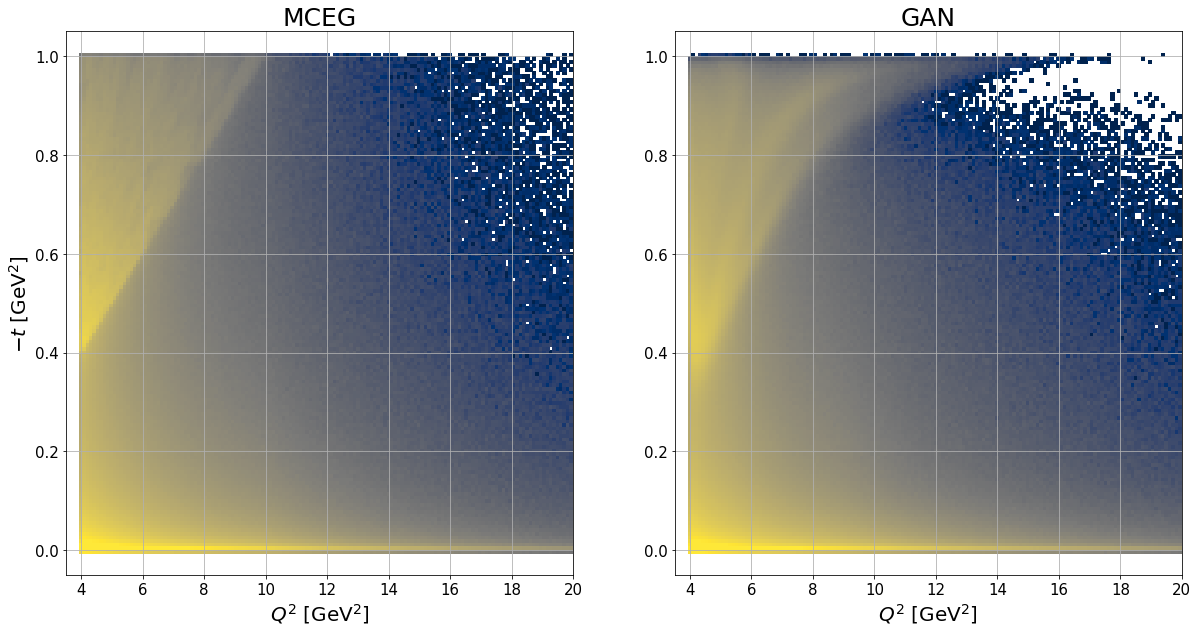

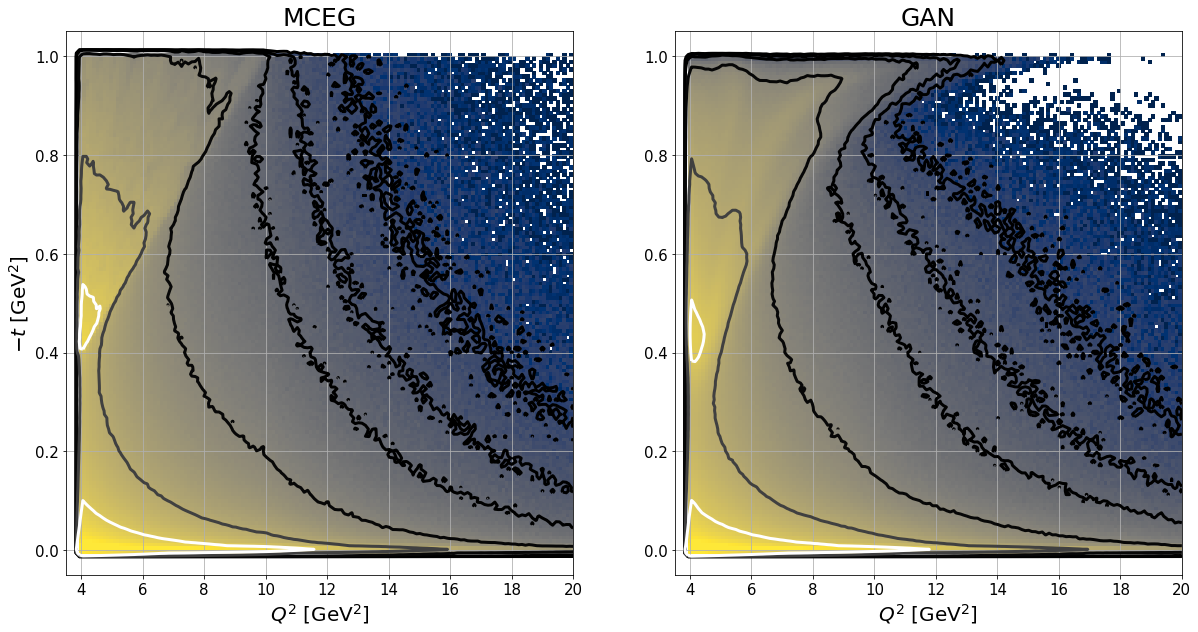

In [17]:
f, axs = plt.subplots(1,2, figsize=(20,10))#; f.tight_layout()
vmin, vmax = 1, 2500*50
xyrange, bins = [[3.5, 20],[-0.05, 1.05]], 150#(500,500)
for ax, hh, lab in zip(axs.flatten(), [train, pred], ["MCEG", "GAN"]):
    ax.hist2d(hh[:,0], hh[:,5-1], bins=bins, range=xyrange, cmap="cividis", norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
    ax.set_xlabel(r"$Q^{2}$ [GeV$^2$]", fontsize=20)
    if lab == "MCEG": ax.set_ylabel(r"$-t$ [GeV$^2$]", fontsize=20)
    ax.set_title(lab, fontsize=25)
    ax.grid()
f.savefig(f"imgs/q2t.png", bbox_inches='tight', dpi=dpi)#, facecolor="white"

f, axs = plt.subplots(1,2, figsize=(20,10))#; f.tight_layout()
for ax, hh, lab in zip(axs.flatten(), [train, pred], ["MCEG", "GAN"]):
    c, xb, yb, im = ax.hist2d(hh[:,0], hh[:,5-1], bins=bins, range=xyrange, cmap="cividis", norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
    ax.contour(c.T,extent=[xb.min(),xb.max(),yb.min(),yb.max()],linewidths=3, cmap=plt.cm.Greys_r, levels=[10, 33, 100, 666, 5000, 25000])#[10, 33, 100, 333, 1000])
    ax.set_xlabel(r"$Q^{2}$ [GeV$^2$]", fontsize=20)
    if lab == "MCEG": ax.set_ylabel(r"$-t$ [GeV$^2$]", fontsize=20)
    ax.set_title(lab, fontsize=25)
    ax.grid()
f.savefig(f"imgs/q2t_lines.png", bbox_inches='tight', dpi=dpi)#, facecolor="white"

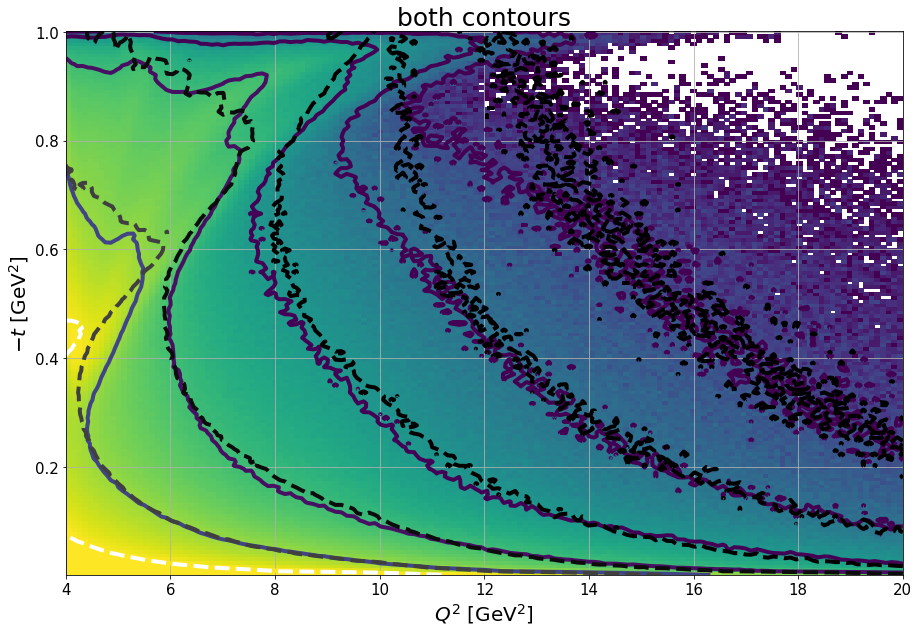

In [18]:
f, ax = plt.subplots(1,1, figsize=(15,10))#; f.tight_layout()
# vmin, vmax = 1, 20000
# xyrange, bins = [[3.5, 20],[-0.05, 1.05]], 150#(500,500)
bins = [np.linspace(4, 20,150+1), np.linspace(0.001, 1.001, 150+1)]
levels=np.logspace(1, 4.5, 6)
vmin, vmax = 1, np.max(levels)
# bins = [np.logspace(np.log10(4), np.log10(20),150+1), np.linspace(0.001, 1.001, 150+1)]

ct, xbt, ybt, imt = ax.hist2d(train[:,0], train[:,5-1], bins=bins)
ax.clear()
cp, xbp, ybp, imp = ax.hist2d(pred[:,0], pred[:,5-1], bins=bins, norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))

ax.contour(cp.T,extent=[xbp.min(),xbp.max(),ybp.min(),ybp.max()],linewidths=4, levels=levels)#[10, 33, 100, 666, 5000, 25000])#[10, 33, 100, 333, 1000])
ax.contour(ct.T,extent=[xbt.min(),xbt.max(),ybt.min(),ybt.max()],linewidths=4, linestyles='dashed', cmap=plt.cm.Greys_r, levels=levels)#[10, 33, 100, 1000, 5000, 25000])#[10, 33, 100, 333, 1000])
ax.set_xlabel(r"$Q^{2}$ [GeV$^2$]", fontsize=20)
ax.set_ylabel(r"$-t$ [GeV$^2$]", fontsize=20)
ax.set_title("both contours", fontsize=25)
# ax.set_xscale('log')
ax.grid()
# f.savefig(f"imgs/q2t_lines.png", bbox_inches='tight', dpi=dpi)#, facecolor="white"

/tmp/ipykernel_26716/72973545.py:18: UserWarning: Log scale: values of z <= 0 have been masked
  csp = ax.contourf(cp.T, extent=[xbp.min(), xbp.max(), ybp.min(), ybp.max()], cmap='tab20', norm=norm, levels=levels)


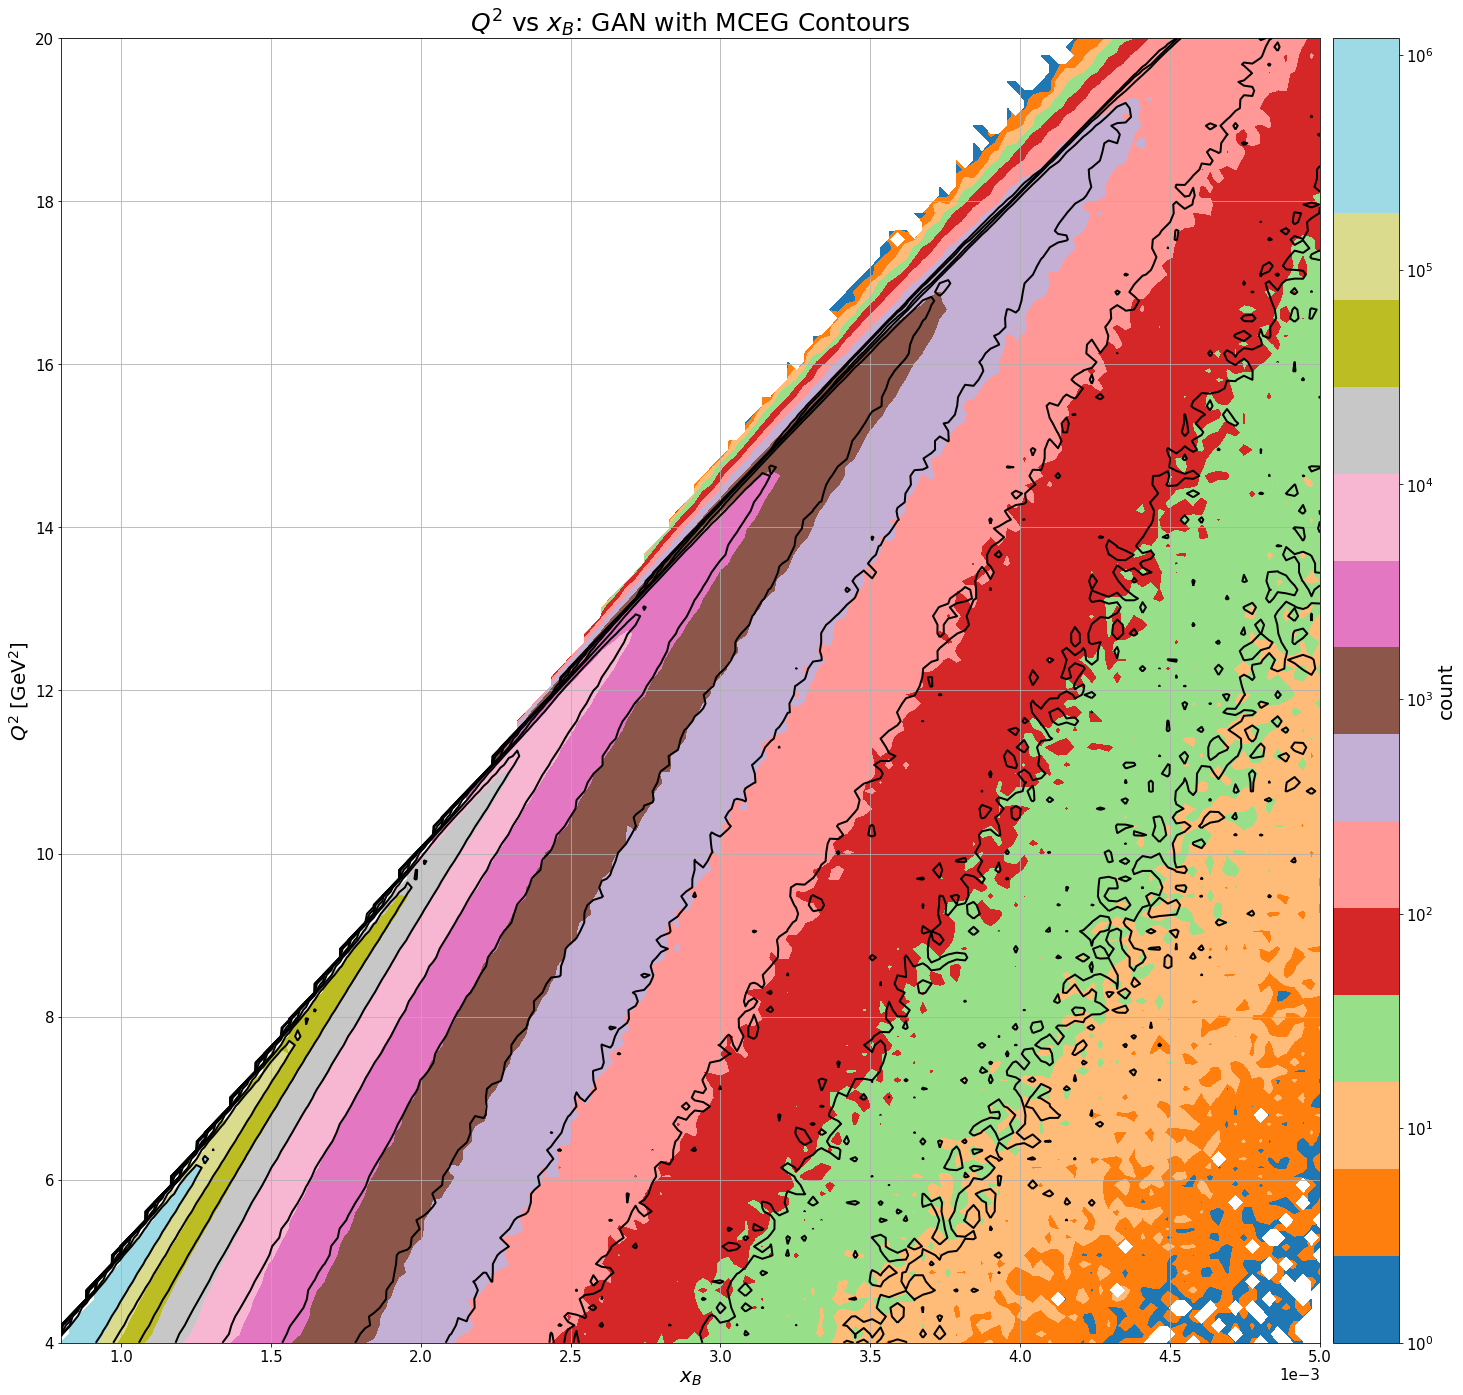

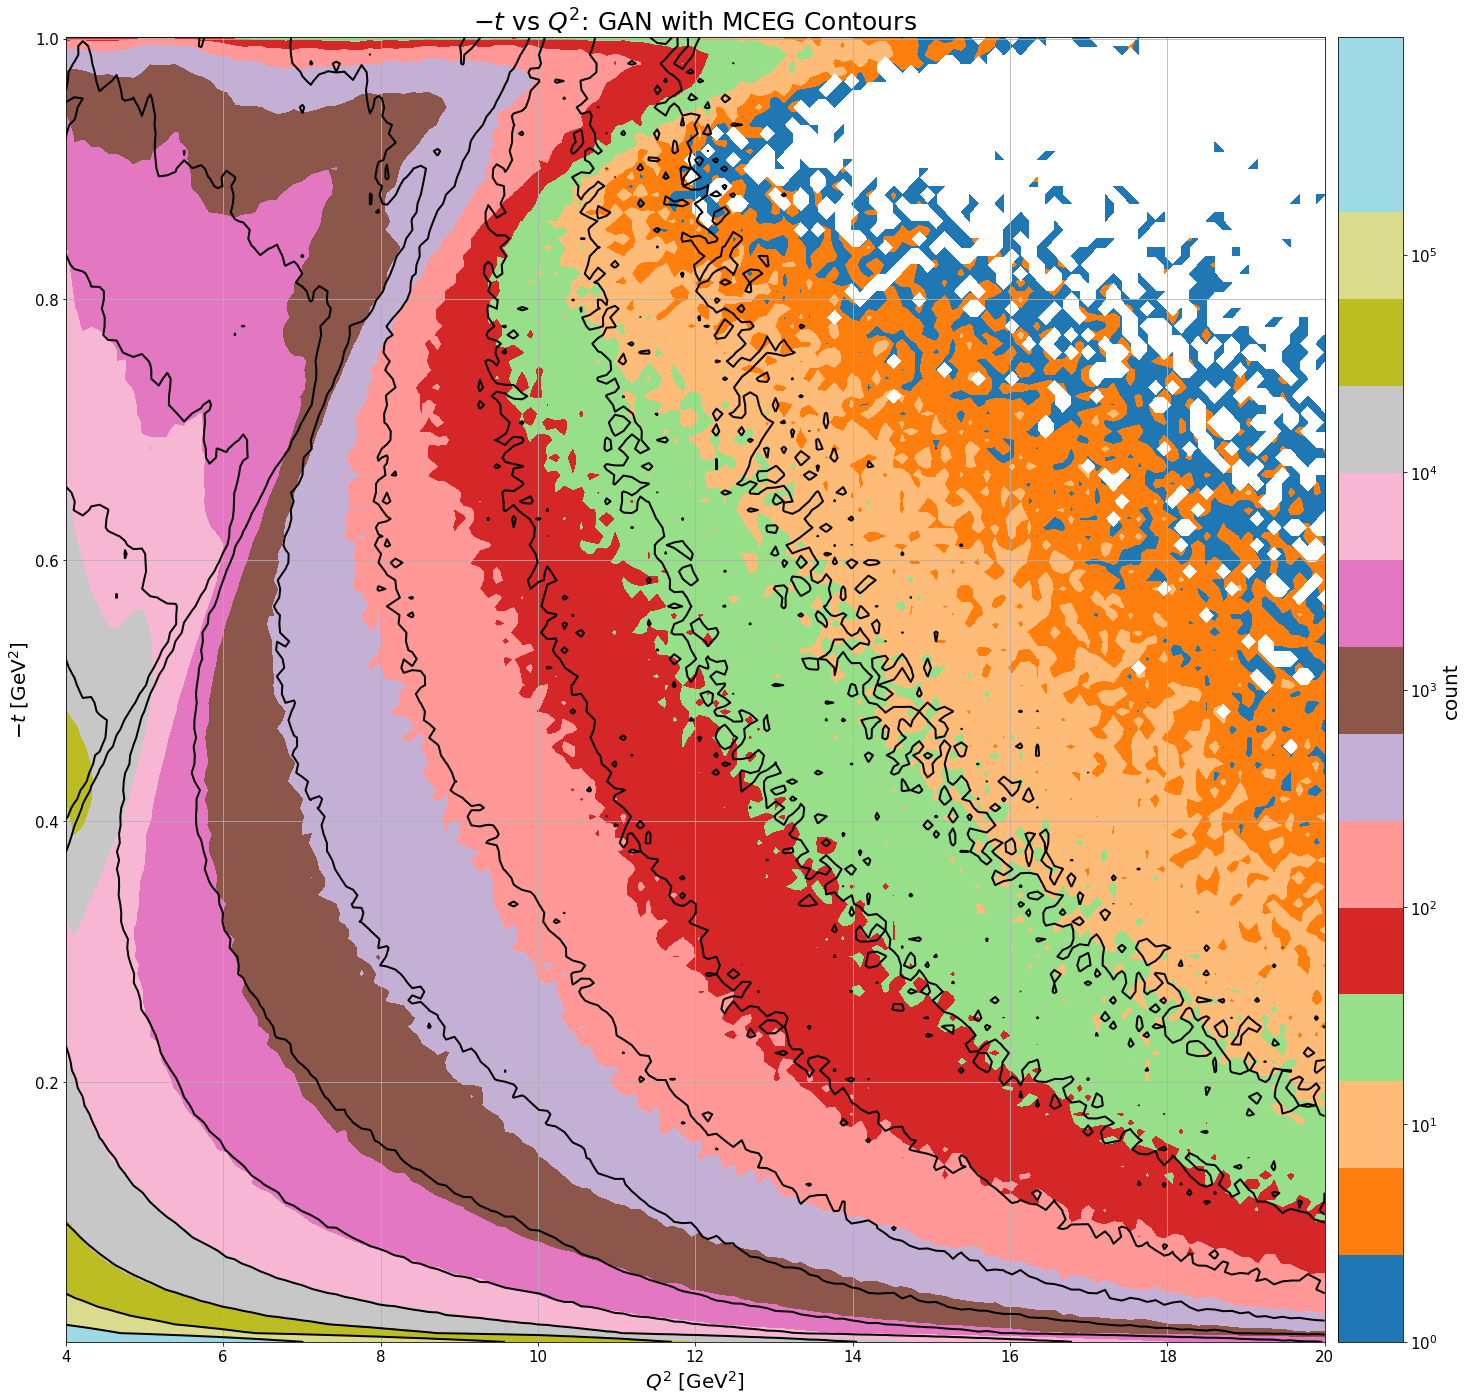

In [19]:

bins_xbq2 = [np.linspace(0.0008,0.005, 150+1), np.linspace(4,20, 150+1)]
info_xbq2 = ("$x_B$", "$Q^2$ [GeV$^2$]", "$Q^2$ vs $x_B$: GAN with MCEG Contours", "xbq2")

bins_q2t = [np.linspace(4,20, 150+1), np.linspace(0.001,1.001, 150+1)]
info_q2t = ("$Q^2$ [GeV$^2$]", "$-t$ [GeV$^2$]", "$-t$ vs $Q^2$: GAN with MCEG Contours", "q2t")

for bins, xi, yi, info in zip([bins_xbq2, bins_q2t], [3-1, 0], [0, 5-1], [info_xbq2, info_q2t]):
    # f, ax = plt.subplots(1,1, figsize=(8,8))#; f.tight_layout()
    f, ax = plt.subplots(1,1, figsize=(24,24))#; f.tight_layout()

    ct, xbt, ybt, imt = ax.hist2d(train[:,xi], train[:,yi], bins=bins)
    cp, xbp, ybp, imp = ax.hist2d(pred[:,xi], pred[:,yi], bins=bins)
    ax.clear()

    levels = np.logspace(0, np.log10(cp.max()), 15+1)
    norm = mpl.colors.LogNorm(vmin=levels[0],vmax=levels[-2])

    csp = ax.contourf(cp.T, extent=[xbp.min(), xbp.max(), ybp.min(), ybp.max()], cmap='tab20', norm=norm, levels=levels)
    cst = ax.contour( ct.T, extent=[xbt.min(), xbt.max(), ybt.min(), ybt.max()], linewidths=2, colors='k',  levels=levels[3:-2])
    cbar = f.colorbar(csp, ax=ax, fraction=0.05, pad=0.01)
    cbar.set_label('count')
    cbar.set_ticks(np.logspace(0, 10, 10+1))

    ax.set_xlabel(info[0], fontsize=20)
    ax.set_ylabel(info[1], fontsize=20)
    ax.set_title(info[2], fontsize=25)
    ax.grid()

    if info[0] == "$x_B$":
        ax.ticklabel_format(axis='x',style='sci', scilimits=(0,0))

    f.savefig(f"imgs/{info[3]}_1plt_contours.png", bbox_inches='tight', dpi=dpi)#, facecolor="white"

In [20]:
# f, axs = plt.subplots(2,1, figsize=(10,12))#; f.tight_layout()
# a, axs, bc = 0, axs.flatten(), 1000

# for i, n in zip([7, 10], ["$\sum p_x / |p|$ %", "$\sum p_y / |p|$ %"]):#, 13], "$\sum p_z / |p|$ %"
#     # axs[a].set_yscale('log')
#     # axs[a].set_xlabel('%', fontsize=20)
#     axs[a].set_title(n, fontsize=20)
#     axs[a].grid()
#     t, p = np.sum(train[:, i:i+3], axis=1) / np.sqrt(np.sum(train[:, 7:10], axis=1)**2 + np.sum(train[:, 10:13], axis=1)**2 + np.sum(train[:, 13:16], axis=1)**2)*100,\
#            np.sum(pred[:, i:i+3], axis=1) / np.sqrt(np.sum(pred[:, 7:10], axis=1)**2 + np.sum(pred[:, 10:13], axis=1)**2 + np.sum(pred[:, 13:16], axis=1)**2)*100
#     # bins = np.linspace(np.min(np.r_[t,p]), np.max(np.r_[t,p]), bc+1)
#     if a < 2:
#         bins = np.linspace(-0.01, 0.01, bc+1)
#     else:
#         bins = np.linspace(99.999, 100.001, bc+1)
#         # bins = np.linspace(np.min(p), np.max(p), bc+1)
#         axs[a].hist(t, bins=bins, histtype="step", linewidth=3, label="MCEG")

#     weights, bb, _ = axs[a].hist(p, bins=bins, histtype="step", linewidth=2, color="C1", label="GAN")

#     hmax = np.max(weights)/2
#     m, s = np.mean(p), np.std(p)
#     print(f"mu = {m:.5f}% sig = {s:.5f}%, FWHM = {(bb[np.where(weights>hmax)[0][-1]] - bb[np.where(weights>hmax)[0][0]]):.5f}%")
#     if a < 2:
#         # axs[a].set_xlim([-.010, .010])
#         ylim = axs[a].get_ylim()
#         axs[a].plot([0, 0], [0, 1e9], 'C0', linewidth=3)
#         axs[a].plot([m - 2 * s, m - 2 * s], [0, 1e9], 'k', linewidth=2)
#         axs[a].plot([m + 2 * s, m + 2 * s], [0, 1e9], 'k', linewidth=2)
#         axs[a].set_ylim(ylim)
#         # axs[a].set_xlim([-.1,.1])
#     axs[a].xaxis.set_major_formatter(FormatStrFormatter('%g'))
#     a+=1

# axs[0].text(.75, .8, "MCEG", transform=axs[0].transAxes, fontsize=45, color='C0')
# axs[0].text(.75, .62, "GAN", transform=axs[0].transAxes, fontsize=45, color='C1')

# f.savefig(f"imgs/mom_conserve.png", facecolor="white", bbox_inches='tight', dpi=dpi)


In [21]:
# f, axs = plt.subplots(2,2, figsize=(20,20)); f.tight_layout()
# vmin, vmax = 1, 10000
# xyrange, bins = [[0.0001, 0.005],[2, 20]], 200#(500,500)
# for ax, hh, lab in zip(axs[0,:].flatten(), [train, pred], ["MCEG", "WGAN-GP"]):
#     ax.hist2d(hh[:,3], hh[:,0], bins=bins, range=xyrange, cmap="cividis", norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
#     mpl_labels(ax, "", r"$Q^{2}$ [GeV]", lab, r"($Q^{2}$ vs $x_{bj})$")
#     # mpl_labels(ax, r"x$_{bj}$", r"Q$^{2}$ [GeV]", lab, r"(Q$^{2}$ vs x$_{bj}$)")

# vmin, vmax = 1, 1000
# xyrange, bins = [[0.0006, 0.002],[3, 8]], 100#(500,500)
# for ax, hh, lab in zip(axs[1,:].flatten(), [train, pred], ["MCEG", "WGAN-GP"]):
#     ax.hist2d(hh[:,3], hh[:,0], bins=bins, range=xyrange, cmap="cividis", norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
#     # mpl_labels(ax, r"x$_{bj}$", r"Q$^{2}$ [GeV]", lab, r"(Q$^{2}$ vs x$_{bj}$)")
#     ax.set_xlabel(r"$x_{B}$")
#     if lab == "MCEG": ax.set_ylabel(r"$Q^{2}$ [GeV]")
#     ax.grid()

# # f.savefig(f"imgs/Q2xbj_comparison.png", bbox_inches='tight', dpi=300)

In [22]:
# f, axs = plt.subplots(2,2, figsize=(20,20)); f.tight_layout()
# vmin, vmax = 1, 15000

# xyrange, bins = [[0.0007, 0.005],[3.5, 20]], 200#(500,500)
# for ax, hh, lab in zip(axs[0,:].flatten(), [train, pred], ["MCEG", "WGAN-GP"]):
#     ax.hist2d(hh[:,3], hh[:,0], bins=bins, range=xyrange, cmap="cividis", norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
#     mpl_labels(ax, "", r"$Q^{2}$ [GeV]", lab, r"(Q$^{2}$ vs $x_{B})$")
#     ax.plot([0.005, 0.000805, 0.002015, 0.00293, 0.004522], [4, 4, 10, 14, 20], 'k', linewidth=8)

# vmin, vmax = 1, 2500
# xyrange, bins = [[0.0007, 0.00125],[3.5, 6]], 75#(500,500)
# for ax, hh, lab in zip(axs[1,:].flatten(), [train, pred], ["MCEG", "WGAN-GP"]):
#     ax.hist2d(hh[:,3], hh[:,0], bins=bins, range=xyrange, cmap="cividis", norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
#     ax.set_xlabel(r"$x_{B}$")
#     if lab == "MCEG": ax.set_ylabel(r"$Q^{2}$ [GeV]")
#     ax.plot([0.005, 0.000805, 0.002015, 0.00293, 0.004522], [4, 4, 10, 14, 20], 'k', linewidth=8)
#     ax.grid()

# # f.savefig(f"imgs/Q2xbj_with_lines.png", bbox_inches='tight', dpi=300)

In [23]:
# f, axs = plt.subplots(1, 2, figsize=(20,10)); f.tight_layout()
# vmin, vmax = 1, 15000
# xyrange, bins = [[3.5, 20],[-0.05, 1.05]], 200#(500,500)
# for ax, hh, lab in zip(axs.flatten(), [train, pred], ["MCEG", "WGAN"]):
#     ax.hist2d(hh[:,0], hh[:,5], bins=bins, range=xyrange, cmap="cividis", norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
#     mpl_labels(ax, r"$Q^2$", r"-t", lab, r"$-t$ vs $Q^{2}$")
#     # ax.plot([0.000805, 0.0012075], [4, 6], 'k:', linewidth=8)
#     # ax.plot([0.0008, 0.00125], [4, 4], 'k:', linewidth=8)
# # f.savefig(f"imgs/Q2t_comparison.png", bbox_inches='tight', dpi=300)

In [24]:
# import ROOT
# ROOT.gStyle.SetOptStat(0)
# ROOT.TGaxis.SetMaxDigits(2)

# TT = ROOT.RDF.MakeNumpyDataFrame({k:v for k,v in zip(param_dict['feat_names'], train.T)})#dict(zip(param_dict['feat_names'], train.T)))#{k:v for k,v in zip(param_dict['feat_names'], train.T)}
# PP = ROOT.RDF.MakeNumpyDataFrame(dict(zip(param_dict['feat_names'], pred.T)))
# print(TT.GetColumnNames())
# print(TT.Count().GetValue())
# # TT.Display().Print()
# # dict(zip(param_dict['feat_names'], train.T))['Q2'].shape

In [25]:
# c1 = ROOT.TCanvas("c1", "c1", 2000, 1000); c1.Divide(3,4); c1.Draw()
# bins = 100
# hlvs_TT = []
# hlvs_PP = []
# for part in ["Electron", "Photon", "Proton"]:
#     lvT, lvP = [], []
#     for mom in [" E", " px", "py", " pz"]:
#         xmin, xmax = TT.Min(f"{part.lower()}{mom}").GetValue(), TT.Max(f"{part.lower()}{mom}").GetValue()
#         lvT.append(TT.Histo1D((f"h{part}{mom}_TT", f"MCEG {part} {mom.lstrip(' ')};{mom};count", bins, xmin, xmax), f"{part.lower()}{mom}"))
#         lvP.append(PP.Histo1D((f"h{part}{mom}_PP", f"WGAN {part} {mom.lstrip(' ')};{mom};count", bins, xmin, xmax), f"{part.lower()}{mom}"))
#     hlvs_TT.append(lvT)
#     hlvs_PP.append(lvP)

# hlvs_TT[0][0].Draw()

# # # nc = 20
# # for i, hh in enumerate([hq2xb_TT, hq2xb_PP]):
# #     c1.cd(i+1).SetGrid(); c1.cd(i+1).SetLogz()
# #     # hh.SetContour(nc, np.append(0, np.logspace(0, 3.2, nc)))
# #     hh.Draw("col")


In [26]:
# c1 = ROOT.TCanvas("c1", "c1", 2000, 1000); c1.Divide(2,1); c1.Draw()
# bins = 500
# xyrange, bins = [[0.0007, 0.005],[3.5, 20]], 200#(500,500)
# ranges = [bins, 0.0001, 0.005, bins, 2, 20]
# hq2xb_TT = TT.Histo2D(("hq2xb_TT", "MCEG Q^{2} vs x_{B};x_{B};Q^{2}", *ranges), "Xbj", "Q2")
# hq2xb_PP = PP.Histo2D(("hq2xb_PP", "WGAN Q^{2} vs x_{B};x_{B};Q^{2}", *ranges), "Xbj", "Q2")

# nc = 20
# for i, hh in enumerate([hq2xb_TT, hq2xb_PP]):
#     c1.cd(i+1).SetGrid(); c1.cd(i+1).SetLogz()
#     hh.SetContour(nc, np.append(0, np.logspace(0, 3.2, nc)))
#     hh.Draw("col")


In [27]:
# c1 = ROOT.TCanvas("c1", "c1", 2000, 1000); c1.Divide(2,1); c1.Draw()
# bins = 75
# ranges = [bins, 0.0007, 0.00126, bins, 3.5, 6]
# hq2xb_TT = TT.Histo2D(("hq2xb_TT", "MCEG Q^{2} vs x_{B};x_{B};Q^{2}", *ranges), "Xbj", "Q2")
# hq2xb_PP = PP.Histo2D(("hq2xb_PP", "WGAN Q^{2} vs x_{B};x_{B};Q^{2}", *ranges), "Xbj", "Q2")

# nc = 20
# for i, hh in enumerate([hq2xb_TT, hq2xb_PP]):
#     c1.cd(i+1).SetGrid(); c1.cd(i+1).SetLogz()
#     hh.SetContour(nc, np.append(0, np.logspace(0, 2.5, nc)))
#     hh.Draw("col")


In [28]:
# c1 = ROOT.TCanvas("c1", "c1", 2000, 1000); c1.Divide(2,1); c1.Draw()
# bins=500
# hq2xb_gan = ROOT.TH2F("hq2xb_gan",     "wGAN-GP;x_{bj};Q^{2} [GeV]", bins, 0.00075, 0.005, bins, 3.75, 20)

# for h, d in zip([hq2xb_topeg, hq2xb_gan], [train, pred]):
#     for q2, xb in d[:,[0,3]]:
#         h.Fill(xb, q2)

# nc = 20
# for i, h in enumerate([hq2xb_topeg, hq2xb_gan]):
#     c1.cd(i+1).SetLogz()
#     c1.cd(i+1).SetGrid()
#     # h.SetContour(nc, np.append(0, np.logspace(0, 2.5, nc)))
#     h.Draw("col")
#     # h.SetContour(5)
#     # h.Draw("cont3 same")
#     # h.SetLineColor(ROOT.kRed)
#     # h.SetLineWidth(3)
# c1.Print('imgs/q2xb.png')

In [29]:
# {bj};Q^{2} [GeV]", bins, 0.00075, 0.005, bins, 3.75, 20)

# for h, d in zip([hq2xb_topeg, hq2xb_gan], [train, pred]):
#     for q2, xb in d[:,[0,3]]:
#         h.Fill(xb, q2)

# nc = 20
# for i, h in enumerate([hq2xb_topeg, hq2xb_gan]):
#     c1.cd(i+1).SetLogz()
#     c1.cd(i+1).SetGrid()
#     # h.SetContour(nc, np.append(0, np.logspace(0, 2.5, nc)))
#     h.Draw("col")
#     # h.SetContour(5)
#     # h.Draw("cont3 same")
#     # h.SetLineColor(ROOT.kRed)
#     # h.SetLineWidth(3)
# c1.Print('imgs/q2xb.png')

In [30]:
# c1 = ROOT.TCanvas("c1", "c1", 2000, 1000); c1.Divide(2,1); c1.Draw()
# bins=300
# hq2xb_topeg = ROOT.TH2F("hq2xb_topeg", "TOPEG;x_{bj};Q^{2} [GeV]",   bins, 0.0008, 0.001, bins, 3.95, 4.75)
# hq2xb_gan = ROOT.TH2F("hq2xb_gan",     "wGAN-GP;x_{bj};Q^{2} [GeV]", bins, 0.0008, 0.001, bins, 3.95, 4.75)

# for h, d in zip([hq2xb_topeg, hq2xb_gan], [train, pred]):
#     for q2, xb in d[:,[0,3]]:
#         h.Fill(xb, q2)

# nc = 20
# for i, h in enumerate([hq2xb_topeg, hq2xb_gan]):
#     c1.cd(i+1).SetLogz()
#     c1.cd(i+1).SetGrid()
#     # h.SetContour(nc, np.append(0, np.logspace(0, 1.5, nc)))
#     h.DrawCopy("colz")
#     # h.SetContour(5)
#     # h.Draw("cont3 same")
#     # h.SetLineColor(ROOT.kRed)
#     # h.SetLineWidth(3)
# c1.Print('imgs/q2xb_zoomed.png')

In [31]:
# c1 = ROOT.TCanvas("c1", "c1", 2000, 1000); c1.Divide(2,1); c1.Draw()
# bins=300
# hq2t_topeg = ROOT.TH2F("hq2t_topeg","TOPEG;Q^{2};-t;count",bins,4,25,bins,0,1)
# hq2t_gan = ROOT.TH2F("hq2t_gan","GAN;Q^{2};-t;count",bins,4,25,bins,0,1)

# for h, d in zip([hq2t_topeg, hq2t_gan], [train, pred]):
#     for q2, t in d[:,[0,5]]:
#         h.Fill(q2, t)

# nc = 20
# for i, h in enumerate([hq2t_topeg, hq2t_gan]):
#     c1.cd(i+1).SetLogz()
#     c1.cd(i+1).SetGrid()
#     # h.SetContour(nc, np.append(0, np.logspace(0, 1.5, nc)))
#     h.Draw("col")
#     # h.SetContour(5)
#     # h.Draw("cont3 same")
#     # h.SetLineColor(ROOT.kRed)
#     # h.SetLineWidth(3)
# c1.Print('imgs/q2t.png')